In [2]:
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K

import matplotlib
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            parts = line.rstrip('\n').split(',')
            coords = np.array([float(x) for x in parts[1:]], dtype='float64')
            res[parts[0]] = coords
    return res

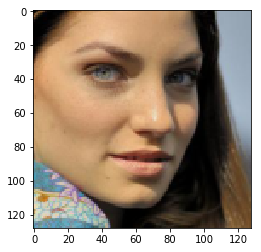

In [7]:
from skimage import io
from scipy import misc
from os.path import join
from keras.preprocessing.image import load_img, img_to_array

in_dir = 'public_data/00_input/train/'
X = np.zeros((100, 128, 128, 3))
Y = np.zeros((100, 28))
Yy = read_csv(join(in_dir, 'gt.csv'))
k = 0
for i in range(0, 100):
    im = load_img(join(in_dir, 'images/' + '{0:05}'.format(i) + '.jpg'))
    im = img_to_array(im)
    n_rows, n_cols, t = im.shape
    im = misc.imresize(im, (128,128, 3))
    im = img_to_array(im)
    X[k] = im.astype('float32')/255.
    p = Yy['{0:05}'.format(i) + '.jpg']
    p[::2] /= n_cols
    p[1::2] /= n_rows
    p *= 128
    Y[k] = p
    k += 1
#     
plt.imshow(X[0])
aver = np.mean(X, axis = 0) # zero-center
disp = np.std(X, axis = 0)

In [8]:
aver = np.array([np.mean(X[:,:,:, i]) for i in range(3)])
disp = np.array([np.std(X[:,:,:, i]) for i in range(3)])
print(aver)
print(disp)

[ 0.56669602  0.45592852  0.39061148]
[ 0.29145999  0.2741567   0.27110229]


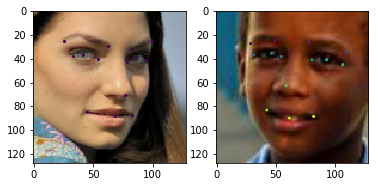

In [12]:
colors = np.arange(10, 65, 4)
plt.subplot(1,2,1)
plt.imshow(X[0])
a = Y[0,::2]
b = Y[0,1::2]
k = 10;
for i,j in zip(b,a):
    plt.scatter(j, i, s=4, c=k)
    k+=1
    
plt.subplot(1,2,2)
plt.imshow(X[1])
plt.scatter(Y[1,::2], Y[1, 1::2], s=4, c=colors)

In [153]:
import pickle
data = {
    'aver':aver, 'disp':disp
}
with open('data.pickle', 'wb') as f:
    pickle.dump(data, f)


In [21]:
import pickle
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)
aver = data['aver']
disp = data['disp']

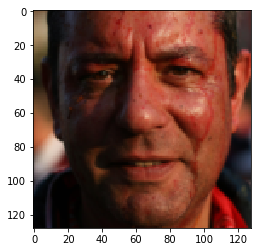

In [3]:
from skimage import io
from scipy import misc
from os.path import join
from keras.preprocessing.image import load_img, img_to_array

in_dir = '/Users/anoshin_alexey/Desktop/ComputerVision/public_data/00_input/train/'
X_test = np.zeros((1000, 128, 128, 3))
Y_test = np.zeros((1000, 28))
Y = read_csv(join(in_dir, 'gt.csv'))
k = 0
for i in range(5000, 6000):
    im = load_img(join(in_dir, 'images/' + '{0:05}'.format(i) + '.jpg'))
    im = img_to_array(im)
    n_rows, n_cols, t = im.shape
    im = misc.imresize(im, (128,128, 3))
    im = img_to_array(im)
    X_test[k] = im.astype('float32')/255.
    p = Y['{0:05}'.format(i) + '.jpg']
    p[::2] /= n_cols
    p[1::2] /= n_rows
#     p *= 128
    Y_test[k] = p
    k += 1
#     

plt.imshow(X_test[0])

In [308]:
X_test -= aver
X_test /= disp

In [46]:
for x in  range(0,3):
    print(x)

0
1
2


In [ ]:
Y = read_csv(join(in_dir, 'gt.csv'))
list(Y.keys())[0]

In [ ]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ActivityRegularization
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler
from keras import regularizers
from keras import backend as K
import math

import random 
from math import cos,sin
from keras.preprocessing import image
from scipy import misc
from scipy.misc import imresize
from skimage import io
from os.path import join

img_rows, img_cols = 128, 128

def random_indices(batchsize, ratio):
    size = int(batchsize * ratio)
    return np.random.choice(batchsize, size, replace=False)

def flip(inputs, targets, batchsize, flip_size):
    """Flip image batch"""
    indices = random_indices(batchsize, flip_size)
#     indices = len(inputs)
#     flip_input = inputs[indices,:,::-1]
    for k in indices:
        inputs[k] = inputs[k,:,::-1]
        targets[k, ::2] = (1-targets[k, ::2])
        p_indices = [(0, 3), (1, 2), (4, 9), (5, 8), (6, 7), (11, 13)]
        for i, j in p_indices:
            targets[k,[2*i, 2*j]] = targets[k,[2*j, 2*i]]
            targets[k,[2*i+1, 2*j+1]] = targets[k,[2*j+1, 2*i+1]]


def rotate(inputs, targets, batchsize, rotate_size):
    indices = random_indices(batchsize, rotate_size)
#     indices = len(inputs)
    for k in indices:
        angle = np.random.randint(-10, 10)
        inputs[k] = misc.imrotate(inputs[k, :, :, :], angle)
        inputs[k] = inputs[k].astype('float32')/255.
        angle = np.radians(angle)
        matrix = np.array([[cos(angle), sin(angle)] ,[-sin(angle), cos(angle)]])
        temp =  np.array(targets[k])
#         print (temp_coords.shape)
        for i in range(0,14):
            temp[2*i: 2*i+2] = temp[2*i: 2*i+2] - 0.5
            temp[2*i: 2*i+2] = matrix.dot(temp[2*i: 2*i+2])
            temp[2*i: 2*i+2] = temp[2*i: 2*i+2] + 0.5
        targets[k] = temp


def crop(inputs, targets, batchsize, crop_size):
    indices = random_indices(batchsize, crop_size)
#     indices = len(inputs)
    for k in indices:
        crop_x = np.random.randint(1, 10) 
        cro_y = np.random.randint(1, 10)
#         print(crop_x)
        imm = np.asarray(inputs[k, crop_y:, crop_x:,:])
        imm = imresize(imm, (img_rows, img_cols))
        imm = imm.astype('float32')/255.
        inputs[k] = imm
        targets[k,1::2] = (targets[k,1::2]*img_rows - crop_y)/(inputs[k, crop_y:, crop_x:]).shape[0]
        targets[k,::2] = (targets[k,::2]*img_cols - crop_x)/(inputs[k, crop_y:, crop_x:]).shape[1]
#     print(inputs.shape)


def yagenerator(folder, gt, batch_size):
    h, w = 128, 128
    names = list(gt.keys())
    names = names[:5000]
    num = len(names)
    #x = np.empty((batch_size, img_rows, img_cols, 3))
    #y = np.empty((batch_size, 28))
    
    while(True):
        random.shuffle(names)
        for i in range(num // batch_size - 1):
            x = np.empty((batch_size, img_rows, img_cols, 3))
            y = np.empty((batch_size, 28))
            
            for j in range(batch_size):
                ind = i * batch_size + j
                name = names[ind]
                #img = imread(join(folder, names[i]))
                img = image.load_img(join(folder, name))
                img = image.img_to_array(img)
                hr = 1 / img.shape[0]
                wr = 1 / img.shape[1]
                img = imresize(img, (h, w), interp='bilinear')
                x[j] = (img.astype('float32'))/255.
                
                y[j] = gt[name].copy()
                y[j, ::2] = y[j, ::2] * wr
                y[j, 1::2] = y[j, 1::2] * hr
            flip(x, y, batch_size, 0.7)
            rotate(x, y, batch_size, 0.6)
            crop(x, y, batch_size, 0.7)
            x -= aver
            x /= disp
#             x[(batch_size//4):2*(batch_size//4)], y[(batch_size//4):2*(batch_size//4)] = flip(
#                 x[:batch_size//4], y[:batch_size//4], batch_size//4)
#             x[2*(batch_size//4):3*(batch_size//4)], y[2*(batch_size//4):3*(batch_size//4)] = rotate(
#                 x[:batch_size//4], y[:batch_size//4], batch_size//4)
#             x[3*(batch_size//4):], y[3*(batch_size//4):] = crop(
#                 x[:batch_size//4], y[:batch_size//4], batch_size//4)
#             for n in range(0,3):
#                     mean_val = np.mean(x[:,:,:,n])
#                     std_val = np.std(x[:,:,:,n])
#                     x[:,:,:,n] = (x[:,:,:,n] - mean_val)/(std_val + 1e-8)
            yield (x, y)




def train_detector(train_gt, train_img_dir, fast_train=True):
    model = Sequential()
    # first set of CONV => RELU => POOL
    model.add(Conv2D(16, (3, 3), padding="same",
        input_shape=(128, 128, 3), data_format='channels_last'))#, kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation("relu"))
    # model.add(ActivityRegularization(l2=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_last'))
    # model.add(Dropout(0.1))
    # model.add(BatchNormalization())
    # second set of CONV => RELU => POOL
    model.add(Conv2D(32, (3, 3), padding="same"))#, kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation("relu"))
    # model.add(ActivityRegularization(l2=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_last'))
    # model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding="same"))#, kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation("relu"))
    # model.add(ActivityRegularization(l2=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_last'))
    # model.add(Dropout(0.2))
    model.add(Conv2D(100, (3, 3), padding="same"))#, kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation("relu"))
    # model.add(ActivityRegularization(l2=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_last'))
    # set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(160))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Dense(28))
    model.add(Activation("sigmoid"))

    print("> Compiling...")
    model.compile(loss = 'mean_squared_error', optimizer='adam')
    
    if fast_train == True:
        model.fit_generator(yagenerator(train_img_dir, train_gt, batch_size=32), steps_per_epoch=4, epochs=10, 
                            verbose=1)
    else: 
        model.fit_generator(yagenerator(train_img_dir, train_gt, batch_size=64), steps_per_epoch=50000//64, epochs=10, 
                    verbose=1, validation_data=(X_test, Y_test))
        
#     return model
        




In [22]:
import numpy as np
import keras
from keras.preprocessing import image
from scipy import misc
from scipy.misc import imresize
from skimage import io
from os.path import join
import os

def detect(model, test_img_dir):
    fnames = [name for name in os.listdir(test_img_dir) if name.endswith(".jpg")]
    points = dict.fromkeys(fnames)
    sizes = dict.fromkeys(fnames)
    batch_size = 64
    img_cols, img_rows = 128, 128
    
    for i in range(len(points) // batch_size + 1):
        x = np.empty((batch_size, img_rows, img_cols, 3))
        y = np.empty((batch_size, 28))

        for j in range(batch_size):
            ind = i * batch_size + j
            if ind >= len(points):
                break
            name = fnames[ind]
            #img = imread(join(folder, names[i]))
            img = image.load_img(join(test_img_dir, name))
            img = image.img_to_array(img)
            sizes[name] = img.shape
            hr = 1 / img.shape[0]
            wr = 1 / img.shape[1]
            img = imresize(img, (img_cols, img_rows), interp='bilinear')
            x[j] = (img.astype('float32'))/255.
            x[j] -= aver
            x[j] /= disp
        y = model.predict(x, batch_size, 0) 
        for j in range(batch_size):
            ind = i * batch_size + j
            if ind >= len(points):
                break
            name = fnames[ind]
            size = sizes[name]
            y[j,::2] *= size[1]
            y[j,1::2] *= size[0]
            points[name] = y[j]
    return points
    

In [23]:
import keras
model = keras.models.load_model('facepoints_model.hdf5')
train_img_dir = '/Users/anoshin_alexey/Desktop/ComputerVision/public_data/00_input/train/images'
points = detect(model, train_img_dir)


In [309]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ActivityRegularization
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler
from keras import regularizers
import math

# X_train, X_test, Y_train, Y_test = train_test_split(X, points, test_size=0.2, random_state=42)
# for n in range(0,3):
#     m = np.mean(X_train[:,:,:,n])
#     s = np.std(X_train[:,:,:,n])
#     X_train[:,:,:,n] = (X_train[:,:,:,n] - m)/(s + 1e-8)
#     m = np.mean(X_test[:,:,:,n])
#     s = np.std(X_test[:,:,:,n])
#     X_test[:,:,:,n] = (X_test[:,:,:,n] - m)/(s + 1e-8)

train_dir = '/Users/anoshin_alexey/Desktop/ComputerVision/public_data/00_input/train'
train_gt = read_csv(join(train_dir, 'gt.csv'))
train_img_dir = join(train_dir, 'images')

model = Sequential()
# first set of CONV => RELU => POOL
model.add(Conv2D(16, (3, 3), padding="same",
    input_shape=(128, 128, 3), data_format='channels_last'))#, kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation("relu"))
# model.add(ActivityRegularization(l2=0.01))
model.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_last'))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())

# second set of CONV => RELU => POOL
model.add(Conv2D(32, (3, 3), padding="same"))#, kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation("relu"))
# model.add(ActivityRegularization(l2=0.01))
model.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_last'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding="same"))#, kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation("relu"))
# model.add(ActivityRegularization(l2=0.01))
model.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_last'))
# model.add(Dropout(0.2))

model.add(Conv2D(100, (3, 3), padding="same"))#, kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation("relu"))
# model.add(ActivityRegularization(l2=0.01))
model.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_last'))
# set of FC => RELU layers
model.add(Flatten())
model.add(Dense(160))
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(28))
model.add(Activation("sigmoid"))
          
# epochs = 2
# learning_rate = 0.1
# decay_rate = learning_rate / epochs
# momentum = 0.8
# sgd = SGD(lr=0.1)
print("> Compiling...")
model.compile(loss = 'mean_squared_error', optimizer='adam')
 
print(model.summary())

train_gt = read_csv(join(train_dir, 'gt.csv'))

# def step_decay(epoch):
#     if epoch > 4:
#         initial_lrate = 0.1
#         drop = 0.5
#         epochs_drop = 10.0
#         lrate = initial_lrate * math.pow(drop,  
#                math.floor((1+epoch)/epochs_drop))
#     else:
#         lrate = 0.1
#     return lrate

# lrate = LearningRateScheduler(step_decay)

model.fit_generator(yagenerator(train_img_dir, train_gt, batch_size=64), steps_per_epoch=1000//64, epochs=10, 
                    verbose=1, validation_data=(X_test, Y_test))
# 9. Fit model on training data
# model.fit(X_train, Y_train, 
#           batch_size=32, epochs=10, verbose=1, validation_data=(X_test, Y_test))


# 10. Evaluate model on test data
# score = model.evaluate(X_test, Y_test, verbose=1)

> Compiling...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_254 (Conv2D)          (None, 128, 128, 16)      448       
_________________________________________________________________
activation_313 (Activation)  (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_251 (MaxPoolin (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_255 (Conv2D)          (None, 64, 64, 32)        4640      
_________________________________________________________________
activation_314 (Activation)  (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_252 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_256 (Conv2D)          (None, 32, 32, 64)        18496 

KeyboardInterrupt: 

In [305]:
import random 
from math import cos,sin
from keras.preprocessing import image
from scipy import misc
from scipy.misc import imresize
from skimage import io
from os.path import join

img_rows, img_cols = 128, 128

def random_indices(batchsize, ratio):
    size = int(batchsize * ratio)
    return np.random.choice(batchsize, size, replace=False)

def flip(inputs, targets, batchsize, flip_size):
    """Flip image batch"""
    indices = random_indices(batchsize, flip_size)
#     indices = len(inputs)
#     flip_input = inputs[indices,:,::-1]
    for k in indices:
        inputs[k] = inputs[k,:,::-1]
        targets[k, ::2] = (1-targets[k, ::2])
        p_indices = [(0, 3), (1, 2), (4, 9), (5, 8), (6, 7), (11, 13)]
        for i, j in p_indices:
            targets[k,[2*i, 2*j]] = targets[k,[2*j, 2*i]]
            targets[k,[2*i+1, 2*j+1]] = targets[k,[2*j+1, 2*i+1]]


def rotate(inputs, targets, batchsize, rotate_size):
    indices = random_indices(batchsize, rotate_size)
#     indices = len(inputs)
    for k in indices:
        angle = np.random.randint(-10, 10)
        inputs[k] = misc.imrotate(inputs[k, :, :, :], angle)
        inputs[k] = inputs[k].astype('float32')/255.
        angle = np.radians(angle)
        matrix = np.array([[cos(angle), sin(angle)] ,[-sin(angle), cos(angle)]])
        temp =  np.array(targets[k])
#         print (temp_coords.shape)
        for i in range(0,14):
            temp[2*i: 2*i+2] = temp[2*i: 2*i+2] - 0.5
            temp[2*i: 2*i+2] = matrix.dot(temp[2*i: 2*i+2])
            temp[2*i: 2*i+2] = temp[2*i: 2*i+2] + 0.5
        targets[k] = temp


def crop(inputs, targets, batchsize, crop_size):
    indices = random_indices(batchsize, crop_size)
#     indices = len(inputs)
    for k in indices:
        crop_x = np.random.randint(1, 10) 
        cro_y = np.random.randint(1, 10)
#         print(crop_x)
        imm = np.asarray(inputs[k, crop_y:, crop_x:,:])
        imm = imresize(imm, (img_rows, img_cols))
        imm = imm.astype('float32')/255.
        inputs[k] = imm
        targets[k,1::2] = (targets[k,1::2]*img_rows - crop_y)/(inputs[k, crop_y:, crop_x:]).shape[0]
        targets[k,::2] = (targets[k,::2]*img_cols - crop_x)/(inputs[k, crop_y:, crop_x:]).shape[1]
#     print(inputs.shape)


def yagenerator(folder, gt, batch_size):
    h, w = 128, 128
    names = list(gt.keys())
    names = names[:5000]
    num = len(names)
    #x = np.empty((batch_size, img_rows, img_cols, 3))
    #y = np.empty((batch_size, 28))
    
    while(True):
        random.shuffle(names)
        for i in range(num // batch_size - 1):
            x = np.empty((batch_size, img_rows, img_cols, 3))
            y = np.empty((batch_size, 28))
            
            for j in range(batch_size):
                ind = i * batch_size + j
                name = names[ind]
                #img = imread(join(folder, names[i]))
                img = image.load_img(join(folder, name))
                img = image.img_to_array(img)
                hr = 1 / img.shape[0]
                wr = 1 / img.shape[1]
                img = imresize(img, (h, w), interp='bilinear')
                x[j] = (img.astype('float32'))/255.
                
                y[j] = gt[name].copy()
                y[j, ::2] = y[j, ::2] * wr
                y[j, 1::2] = y[j, 1::2] * hr
            flip(x, y, batch_size, 0.7)
            rotate(x, y, batch_size, 0.6)
            crop(x, y, batch_size, 0.7)
            x -= aver
            x /= disp
#             x[(batch_size//4):2*(batch_size//4)], y[(batch_size//4):2*(batch_size//4)] = flip(
#                 x[:batch_size//4], y[:batch_size//4], batch_size//4)
#             x[2*(batch_size//4):3*(batch_size//4)], y[2*(batch_size//4):3*(batch_size//4)] = rotate(
#                 x[:batch_size//4], y[:batch_size//4], batch_size//4)
#             x[3*(batch_size//4):], y[3*(batch_size//4):] = crop(
#                 x[:batch_size//4], y[:batch_size//4], batch_size//4)
#             for n in range(0,3):
#                     mean_val = np.mean(x[:,:,:,n])
#                     std_val = np.std(x[:,:,:,n])
#                     x[:,:,:,n] = (x[:,:,:,n] - mean_val)/(std_val + 1e-8)
            yield (x, y)



In [257]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# X_train, X_test, Y_train, Y_test = train_test_split(X, points, test_size=0.33, random_state=42)

# datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# # fit parameters from data
# datagen.fit(X_train)


output_units = 28
train_size = 4500
batch_size = 64
valid_size = 1500

model = Sequential()

model.add(Conv2D(6, 28, 28, activation = 'relu', input_shape=(128,128,3), init='normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, 10, 10, activation = 'relu', init='normal'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# Flatten the 3D output to 1D tensor for a fully connected layer to accept the input
model.add(Flatten())
model.add(Dense(120, activation = 'relu', init='normal'))
model.add(Dense(84, activation = 'relu', init='normal'))
# model.add(Dropout(0.5))
model.add(Dense(output_units, init='normal', activation='sigmoid'))
# model.add(BatchNormalization())


epochs = 2
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, decay=decay_rate, momentum=momentum)
print("> Compiling...")
model.compile(loss = 'mean_squared_error', optimizer=sgd)
 
# 9. Fit model on training data
# model.fit(X_train, Y_train, 
#           batch_size=128, epochs=10, verbose=1)
model.fit_generator(generator=training_generator,
                    epochs=2,
                    steps_per_epoch = train_size//batch_size,
                    verbose=1,
                    validation_data = validation_generator,
                    validation_steps = valid_size//batch_size)

> Compiling...


/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (28, 28), activation="relu", input_shape=(128, 128,..., kernel_initializer="normal")`
/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (10, 10), activation="relu", kernel_initializer="normal")`
/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(120, activation="relu", kernel_initializer="normal")`
/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(84, activation="relu", kernel_initializer="normal")`
/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(28, activation="sigmoid", kernel_initializ

NameError: name 'training_generator' is not defined

In [26]:
in_dir='/Users/anoshin_alexey/Desktop/ComputerVision/public_data/00_input/train/'
Y = read_csv(join(in_dir, 'gt.csv'))
Y['00000.jpg']

array([  51.,   51.,  127.,   60.,  169.,   65.,  203.,   52.,   68.,
         77.,   85.,   75.,  110.,   82.,  160.,   87.,  171.,   79.,
        193.,   84.,  156.,  144.,   92.,  174.,  140.,  180.,  168.,  179.])

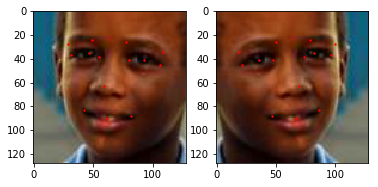

In [249]:
import numpy as np
import skimage.transform as sk
from PIL import Image, ImageDraw
inputs = X[1].copy()
targets = Y[1].copy()
indices = np.array([])
plt.subplot(1,2,1)
plt.imshow((inputs))
x = targets[::2]
y = targets[1::2]
plt.scatter(x,y, c='r', s=2)
img = Image.fromarray(np.uint8(inputs*255))
draw = ImageDraw.Draw(img)
for k in range(14):
    xx = x[k]
    yy = y[k]
    draw.text((xx, yy - 5), str(k), (255, 0, 0))#, font=font)

img.save('0.png')
# print(targets[1, ::2])
# print(targets[1, 1::2])
plt.subplot(1,2,2)
inputs = inputs[:,::-1]
plt.imshow((inputs))
# print(targets[1, ::2])
# print(targets[1, 1::2])
targets[ ::2] = -targets[ ::2] + inputs.shape[0]
p_indices = [(0, 3), (1, 2), (4, 9), (5, 8), (6, 7), (11, 13)]
for i, j in p_indices:
    targets[[2*i, 2*j]] = targets[[2*j, 2*i]]
    targets[[2*i+1, 2*j+1]] = targets[[2*j+1, 2*i+1]]
#     targets[indx,1::2] = pp
x =targets[::2]
y = targets[1::2]
plt.scatter(x,y, c='r', s=2)
img = Image.fromarray(np.uint8(inputs*255))
draw = ImageDraw.Draw(img)
for k in range(14):
    xx = x[k]
    yy = y[k]
    draw.text((xx, yy - 5), str(k), (255, 0, 0))#, font=font)

img.save('1.png')
# print(targets[1, ::2])
# print(targets[1, 1::2])
# print(len(targets[1]))

In [91]:
import numpy as np
import skimage.transform as sk
from scipy import misc
from math import cos,sin

inputs = X[24:28].copy()
targets = points[24:28].copy()
indices = np.array([1,3])
plt.subplot(1,2,1)
plt.imshow(np.uint8(inputs[1]))
x =targets[1,::2]
y = targets[1,1::2]
plt.scatter(x,y, c='r', s=2)
# angle = 10
# num_points=14
# for indx in indices:
#     inputs[indx] = misc.imrotate(inputs[indx, :, :, :], angle)
#     angle = np.radians(angle)
#     matrix = np.array([[cos(angle), sin(angle)] ,[-sin(angle), cos(angle)]])
#     temp =  np.array(targets[indx])
#     print (temp_coords.shape)
#     for i in range(0,14):
#         temp[2*i: 2*i+2] = temp[2*i: 2*i+2] - 128/2
#         temp[2*i: 2*i+2] = matrix.dot(temp[2*i: 2*i+2])
#         temp[2*i: 2*i+2] = temp[2*i: 2*i+2] + 128/2
#     targets[indx] = temp

crop_x =10
crop_y = 15
for i in indices:
    inputs[i] = misc.imresize(inputs[i, crop_y:, crop_x:], inputs[i].shape)
    targets[i,1::2] = (targets[i,1::2] - crop_y)*128/(inputs[i, crop_y:, crop_x:]).shape[0]
    targets[i,::2] = (targets[i,::2] - crop_x)*128/(inputs[i, crop_y:, crop_x:]).shape[1]
    
x =targets[1,::2]
y = targets[1,1::2]
plt.subplot(1,2,2)
plt.imshow(np.uint8(inputs[1]))
plt.scatter(x,y, c='r', s=2)

NameError: name 'X' is not defined

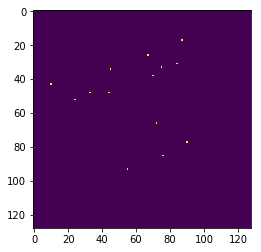

In [46]:
plt.imshow(mask[1,:,::-1])

In [ ]:
im = X[1].copy()
t = np.asarray(np.around(points[1]), dtype='int')
print(points[1])
Y = np.zeros((im.shape[0], im.shape[1]))
Y[t[1::2],t[::2]] = 255
Y1 = sk.rotate(Y, angle)
plt.subplot(1,2,1)
plt.imshow(Y)
plt.subplot(1,2,2)
plt.imshow(Y1)
j,g =np.where(Y1)
p = np.zeros(28);
j = [j[i]for i in range(3, len(j), 4)]
g = [g[i] for i in range(3, len(g), 4)]
p[1::2] = j
p[::2] = g
print(p)
print(targets[1])

In [ ]:
j,g =np.where(Y[:,::-1] )
p = np.zeros(28);
p[1::2] = j
p[::2] = g
p

In [ ]:
j[0:4]

In [ ]:
from numpy import array
from os import environ
from os.path import join
from sys import argv


def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            parts = line.rstrip('\n').split(',')
            coords = array([float(x) for x in parts[1:]], dtype='float64')
            res[parts[0]] = coords
    return res

def save_csv(facepoints, filename):
    with open(filename, 'w') as fhandle:
        print('filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14',
                file=fhandle)
        for filename in sorted(facepoints.keys()):
            points_str = ','.join(map(str, facepoints[filename]))
            print('%s,%s' % (filename, points_str), file=fhandle)


def check_test(output_dir, gt_dir):

    def read_img_shapes(gt_dir):
        img_shapes = {}
        with open(join(gt_dir, 'img_shapes.csv')) as fhandle:
            next(fhandle)
            for line in fhandle:
                parts = line.rstrip('\n').split(',')
                filename = parts[0]
                n_rows, n_cols = map(int, parts[1:])
                img_shapes[filename] = (n_rows, n_cols)
        return img_shapes

    def compute_metric(detected, gt, img_shapes):
        res = 0.0
        for filename, coords in detected.items():
            n_rows, n_cols = img_shapes[filename]
            diff = (coords - gt[filename])
            diff[::2] /= n_cols
            diff[1::2] /= n_rows
            diff *= 100
            res += (diff ** 2).mean()
        return res / len(detected.keys())

    detected = read_csv(join(output_dir, 'output.csv'))
    gt = read_csv(join(gt_dir, 'gt.csv'))
    img_shapes = read_img_shapes(gt_dir)
    error = compute_metric(detected, gt, img_shapes)

    return 'Ok, error %.4f' % error


def grade(results_list):
    test_data_result = results_list[-1]

    result = test_data_result['result']
    if not result.startswith('Ok'):
        return '', 0

    error_str = result[10:]
    error = float(error_str)

    if error <= 9:
        mark = 10
    elif error <= 11:
        mark = 9
    elif error <= 13:
        mark = 8
    elif error <= 15:
        mark = 7
    elif error <= 17:
        mark = 6
    elif error <= 20:
        mark = 5
    elif error <= 50:
        mark = 2
    else:
        mark = 0

    return error_str, mark


def run_single_test(data_dir, output_dir):
    from detection import train_detector, detect
    from keras import backend as K
    from keras.models import load_model
    from os import environ
    from os.path import abspath, dirname, join

    train_dir = join(data_dir, 'train')
    test_dir = join(data_dir, 'test')

    train_gt = read_csv(join(train_dir, 'gt.csv'))
    train_img_dir = join(train_dir, 'images')

    train_detector(train_gt, train_img_dir, fast_train=True)

    code_dir = dirname(abspath(__file__))
    model = load_model(join(code_dir, 'model.hdf5'))
    test_img_dir = join(test_dir, 'images')
    detected_points = detect(model, test_img_dir)
    save_csv(detected_points, join(output_dir, 'output.csv'))

    if environ.get('KERAS_BACKEND') == 'tensorflow':
        K.clear_session()


if __name__ == '__main__':
    if environ.get('CHECKER'):
        # Script is running in testing system, run on single input
        if len(argv) != 3:
            print('Usage: %s data_dir output_dir' % argv[0])
            exit(0)

        run_single_test(argv[1], argv[2])
    else:
        # Script is running locally, run on dir with tests
        if len(argv) != 2:
            print('Usage: %s tests_dir' % argv[0])
            exit(0)

        from glob import glob
        from re import sub
        from time import time
        from traceback import format_exc
        from os import makedirs

        tests_dir = argv[1]

        results = []
        for input_dir in sorted(glob(join(tests_dir, '[0-9][0-9]_input'))):
            output_dir = sub('input$', 'output', input_dir)
            makedirs(output_dir, exist_ok=True)
            gt_dir = sub('input$', 'gt', input_dir)

            try:
                start = time()
                run_single_test(input_dir, output_dir)
                end = time()
                running_time = end - start
            except:
                result = 'Runtime error'
                traceback = format_exc()
            else:
                try:
                    result = check_test(output_dir, gt_dir)
                except:
                    result = 'Checker error'
                    traceback = format_exc()

            test_num = input_dir[-8:-6]
            if result == 'Runtime error' or result == 'Checker error':
                print(test_num, result, '\n', traceback)
                results.append({'result': result})
            else:
                print(test_num, '%.2fs' % running_time, result)
                results.append({
                    'time': running_time,
                    'result': result})

        description, mark = grade(results)
        print('Mark:', mark, description)

In [24]:
gt_dir = '/Users/anoshin_alexey/Desktop/ComputerVision/public_data/00_gt'
def read_img_shapes(gt_dir):
    img_shapes = {}
    with open(join(gt_dir, 'img_shapes.csv')) as fhandle:
        next(fhandle)
        for line in fhandle:
            parts = line.rstrip('\n').split(',')
            filename = parts[0]
            n_rows, n_cols = map(int, parts[1:])
            img_shapes[filename] = (n_rows, n_cols)
    return img_shapes

def compute_metric(detected, gt, img_shapes):
    res = 0.0
    for filename, coords in detected.items():
        n_rows, n_cols = img_shapes[filename]
        diff = (coords - gt[filename])
        diff[::2] /= n_cols
        diff[1::2] /= n_rows
        diff *= 100
        res += (diff ** 2).mean()
    return res / len(detected.keys())

detected = points
gt = read_csv(join(gt_dir, 'gt.csv'))
img_shapes = read_img_shapes(gt_dir)
error = compute_metric(detected, gt, img_shapes)
print('Ok, error %.4f' % error)

Ok, error 3.7899


In [17]:
points['00000.jpg']

array([  65.44857025,   48.94746399,  116.1426239 ,   56.43805313,
        162.17982483,   59.59277344,  200.21641541,   52.87414932,
         70.38394928,   72.46789551,   89.1213913 ,   74.62063599,
        107.03957367,   76.2264328 ,  162.10089111,   78.65768433,
        176.51950073,   78.13749695,  191.45372009,   78.45321655,
        151.91340637,  136.80366516,   96.78710938,  170.25149536,
        140.07611084,  175.54827881,  168.67068481,  171.05899048], dtype=float32)